<a href="https://www.kaggle.com/code/tejasurya/unet-from-scratch-segmentation-tumour?scriptVersionId=131333196" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="background-color:red;color:white;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid black">Brain MRI Detector | Segmentation | Using UNet</p>

<center><img src= "https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2014/10/30/15/17/mcdc7_brain_cancer-8col.jpg" alt ="Brain-MRI" style='width:300px;'></center>

**Image source** : Mayo Clinic

# Quick Index

* [Introduction](#1)
* [What is Image Segmentation?](#1.1)
* [EDA](#2)
* [Image Visualization](#2.1)
* [Data Generator](#3)
* [Build UNet](#4)
    * [UNet Architecture](#4.1)
* [UNet Implementation](#5)    
    * [Callbacks](#5.1)
    * [Performance Metrics](#5.2)
    * [Model Fit](#5.3)
    * [Save UNet Model](#5.4)
* [Evaluation](#6)
* [Prediction](#7)

# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Introduction</span> <a id=1></a> 
A brain tumor is a mass or growth of abnormal cells in your brain.Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). Brain tumors can begin in your brain (primary brain tumors), or cancer can begin in other parts of your body and spread to your brain as secondary (metastatic) brain tumors.

How quickly a brain tumor grows can vary greatly. The growth rate as well as the location of a brain tumor determines how it will affect the function of your nervous system.

Brain tumor treatment options depend on the type of brain tumor you have, as well as its size and location. <br>
**Source credits** : [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084)

# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">What is Image Segmentation?</span> <a id=1.1></a> <br> 
 *  The objective of the Image Segmentation is to classify each pixel of an image with the class it represents, by predicting each pixel in image. <br>
 *  Here in this notebook,we will implement the U-Net model, its a U-shaped architecture (in keras). 
We will also apply our model to a Brain MRI tumor detection problem to see how it performs.

# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Import Libraries</span> <a id=1.1.1></a> <br>

In [ ]:
# Librerías estándar
import os
import time
import glob
import random
# import warnings

# warnings.filterwarnings("ignore")

# Librerías de ciencia de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter/IPython
from IPython.display import Image, display

# Procesamiento de imágenes
from skimage import io
from skimage.color import rgb2gray
import cv2

# Machine Learning y Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

# import tensorflow as tf
from tensorflow.keras import layers, optimizers, backend as K # type: ignore
from tensorflow.keras.layers import ( # type: ignore
    Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D,
    Conv2DTranspose, MaxPooling2D, concatenate
)
from tensorflow.keras.models import Model, load_model, save_model # type: ignore
from tensorflow.keras.callbacks import ( # type: ignore
    ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
)
from tensorflow.keras.initializers import glorot_uniform # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore

Las líneas de código siguientes tienen como objetivo cargar y explorar un conjunto de datos relacionado con imágenes de resonancia magnética del cerebro. En primer lugar, se utiliza la función pd.read_csv() de la biblioteca pandas para leer un archivo CSV llamado data.csv, ubicado en una ruta específica. Este archivo contiene información relevante sobre los tumores y los pacientes. Al hacerlo, se crea un objeto DataFrame denominado img_data, que permite manipular y analizar los datos de manera eficiente.

Para facilitar la comprensión de la información cargada, se emplea la función img_data.head(), que muestra las primeras cinco filas del DataFrame. Esto proporciona una vista rápida de la estructura y el contenido de los datos, permitiendo al usuario tener una mejor idea de la información disponible para el análisis y la segmentación de las imágenes de los tumores cerebrales.

In [2]:
img_data = pd.read_csv('data/input/Brain MRI segmentation/kaggle_3m/data.csv')
img_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


La línea de código `img_data.info()` se utiliza para obtener un resumen detallado de la estructura del DataFrame `img_data`, que contiene los datos cargados desde el archivo CSV. Al ejecutarla, se genera un informe que incluye el número de entradas y columnas, los nombres de cada columna, el tipo de datos de cada una y la cantidad de valores no nulos. Esta información es crucial para evaluar la calidad de los datos, identificar posibles problemas como valores faltantes y comprender la estructura general del conjunto de datos antes de realizar análisis más profundos.

In [3]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

La expresión `img_data.shape` se utiliza para obtener las dimensiones del DataFrame `img_data`, que contiene los datos cargados desde el archivo CSV. Al acceder a esta propiedad, se devuelve una tupla que indica el número de filas y columnas en el DataFrame. Esto es útil para comprender el tamaño del conjunto de datos, lo que ayuda a planificar análisis posteriores y optimizar las operaciones que se realizarán en los datos.

In [4]:
img_data.shape

(110, 18)

El código proporcionado tiene como objetivo construir una lista de rutas de archivos para las imágenes y máscaras de un conjunto de datos de resonancia magnética del cerebro. 

Primero, se inicializa una lista vacía llamada `data_path`. Luego, se define un patrón de ruta utilizando `os.path.join()` para crear una ruta compatible que apunte a las subcarpetas del conjunto de datos. A continuación, se utiliza `glob.glob()` para buscar todas las subcarpetas que coincidan con el patrón especificado.

Dentro de un bucle, se verifica si cada subcarpeta es un directorio. Si es así, se obtiene el nombre del directorio y se itera sobre los archivos en esa subcarpeta. Para cada archivo, se construye la ruta completa utilizando `os.path.join()` y se agrega a la lista `data_path`, junto con el nombre del directorio. Si ocurre algún error durante este proceso, se captura la excepción y se imprime el mensaje de error.

In [5]:
data_path = []

# Construir la ruta de forma compatible
path_pattern = os.path.join('data', 'input', 'Brain MRI segmentation', 'kaggle_3m', '*')

for sub_dir_path in glob.glob(path_pattern):
    try:
        if os.path.isdir(sub_dir_path):  # Verifica si es un directorio
            dir_name = os.path.basename(sub_dir_path)
            for filename in os.listdir(sub_dir_path):
                mask_path = os.path.join(sub_dir_path, filename)  # Usa os.path.join para construir la ruta
                data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

Mostrar el contenido de:

In [6]:
data_path

['TCGA_CS_4941_19960909',
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_1.tif',
 'TCGA_CS_4941_19960909',
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif',
 'TCGA_CS_4941_19960909',
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif',
 'TCGA_CS_4941_19960909',
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif',
 'TCGA_CS_4941_19960909',
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11_mask.tif',
 'TCGA_CS_4941_19960909',
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif',
 'TCGA_CS_4941_19960909',
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12_mask.tif',
 'TCGA_CS_4941_19960909',
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\

En el código, `filenames` y `masks` se utilizan para separar las rutas de los archivos de imágenes y máscaras de segmentación almacenadas en la lista `data_path`. La variable `filenames` se asigna a los elementos de `data_path` que están en las posiciones pares, lo que representa las rutas de las imágenes de los pacientes. Por otro lado, `masks` se asigna a los elementos en las posiciones impares de `data_path`, que corresponden a las rutas de las máscaras de segmentación. Esta separación permite acceder fácilmente a las imágenes y sus respectivas máscaras para su posterior procesamiento en el análisis de datos.

In [7]:
filenames = data_path[::2]
masks = data_path[1::2]

En esta línea de código, se crea un DataFrame llamado `df` utilizando la biblioteca `pandas`. Este DataFrame se construye a partir de un diccionario que contiene dos claves: `"patient_id"` y `"img_path"`. La clave `"patient_id"` se asigna a la lista `filenames`, que contiene las rutas de las imágenes de los pacientes, mientras que la clave `"img_path"` se asigna a la lista `masks`, que contiene las rutas de las máscaras de segmentación correspondientes. Al final, el DataFrame `df` organiza esta información en un formato tabular, facilitando el acceso y la manipulación de los datos relacionados con las imágenes y sus respectivas máscaras para el análisis posterior.

In [8]:
df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})
df

,patient_id,img_path
0,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...
1,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...
2,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...
3,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...
4,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...
...,...,...
7853,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...
7854,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...
7855,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...
7856,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...


En estas líneas de código, se filtran las filas del DataFrame `df` para separar las imágenes originales de las máscaras de segmentación. La variable `original_img` se asigna a las filas del DataFrame que no contienen la palabra "mask" en la columna `'img_path'`, lo que significa que incluye solo las rutas de las imágenes originales de los pacientes. Por otro lado, la variable `mask_img` se asigna a las filas que sí contienen "mask" en la columna `'img_path'`, lo que indica que incluye solo las rutas de las máscaras de segmentación. Este proceso de filtrado permite organizar y acceder fácilmente a las imágenes y sus respectivas máscaras para su análisis posterior.

In [9]:
original_img = df[~df['img_path'].str.contains("mask")]
mask_img     = df[df['img_path'].str.contains("mask")]

La línea de código print(original_img["img_path"].values) se utiliza para mostrar en la consola las rutas de las imágenes originales almacenadas en la columna 'img_path' del DataFrame original_img. Al acceder a original_img["img_path"], se obtiene una serie que contiene todas las rutas de las imágenes originales, y al utilizar .values, se extraen esos valores en forma de un arreglo de NumPy. Esto permite visualizar rápidamente las rutas de las imágenes originales, facilitando la verificación y el análisis de los datos.

In [10]:
print(original_img["img_path"].values)

['data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_1.tif'
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif'
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif'
 ...
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_HT_A61B_19991127\\TCGA_HT_A61B_19991127_87.tif'
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_HT_A61B_19991127\\TCGA_HT_A61B_19991127_88.tif'
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_HT_A61B_19991127\\TCGA_HT_A61B_19991127_9.tif']


La línea de código `print(mask_img["img_path"].values)` se utiliza para mostrar en la consola las rutas de las máscaras de segmentación almacenadas en la columna `'img_path'` del DataFrame `mask_img`. Al acceder a `mask_img["img_path"]`, se obtiene una serie que contiene todas las rutas de las máscaras, y al utilizar `.values`, se extraen esos valores en forma de un arreglo de NumPy. Esto permite visualizar rápidamente las rutas de las máscaras de segmentación, facilitando la verificación y el análisis de los datos relacionados con las imágenes.

In [11]:
print(mask_img["img_path"].values)

['data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif'
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11_mask.tif'
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12_mask.tif'
 ...
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_HT_A61B_19991127\\TCGA_HT_A61B_19991127_88_mask.tif'
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_HT_A61B_19991127\\TCGA_HT_A61B_19991127_8_mask.tif'
 'data\\input\\Brain MRI segmentation\\kaggle_3m\\TCGA_HT_A61B_19991127\\TCGA_HT_A61B_19991127_9_mask.tif']


In [12]:
# Prueba de impresión del número que identifica al primer archivo
original_img["img_path"].values[0][88:-4]

'1'

En este fragmento de código, se ordenan las rutas de las imágenes originales y las máscaras de segmentación. La variable imgs se asigna a las rutas de las imágenes originales, ordenadas utilizando la función sorted(). La clave de ordenación se define mediante una función lambda que convierte una parte de la ruta (específicamente, los caracteres entre las posiciones 88 y el final menos 4) en un entero, lo que permite ordenar las imágenes según un identificador numérico.

De manera similar, la variable masks se asigna a las rutas de las máscaras, ordenadas de la misma manera, pero extrayendo los caracteres entre las posiciones 88 y el final menos 9 para ajustarse a la estructura de las rutas de las máscaras.

Luego, se genera un índice aleatorio idx utilizando random.randint(0, len(imgs)-1), que selecciona un número entero aleatorio entre 0 y el tamaño de la lista imgs menos uno. Esto asegura que el índice esté dentro del rango válido de la lista.

Luego, se imprime en la consola la ruta de la imagen correspondiente al índice aleatorio (imgs[idx]) y la ruta de la máscara correspondiente al mismo índice (masks[idx]). La salida muestra ambas rutas, lo que permite al usuario verificar visualmente que las imágenes y sus respectivas máscaras están correctamente emparejadas y alineadas tras el proceso de ordenación.

In [13]:
imgs = sorted(original_img["img_path"].values, key=lambda x : int(x[88:-4]))
masks = sorted(mask_img["img_path"].values, key=lambda x : int(x[88:-9]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: data\input\Brain MRI segmentation\kaggle_3m\TCGA_DU_5849_19950405\TCGA_DU_5849_19950405_24.tif 
Mask path: data\input\Brain MRI segmentation\kaggle_3m\TCGA_DU_5849_19950405\TCGA_DU_5849_19950405_24_mask.tif


En esta línea de código, se crea un nuevo DataFrame llamado `mri_df` utilizando la biblioteca `pandas`. Este DataFrame se construye a partir de un diccionario que contiene tres claves: `"patient_id"`, `"img_path"` y `"mask_path"`. La clave `"patient_id"` se asigna a los identificadores de los pacientes extraídos de `original_img.patient_id.values`, mientras que las claves `"img_path"` y `"mask_path"` se asignan a las listas `imgs` y `masks`, que contienen las rutas de las imágenes originales y sus respectivas máscaras, respectivamente. Al final, el DataFrame `mri_df` organiza esta información en un formato tabular, facilitando el acceso y la manipulación de los datos relacionados con las imágenes de resonancia magnética y sus máscaras de segmentación para análisis posteriores.

In [14]:
mri_df = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                           'mask_path':masks})
mri_df

,patient_id,img_path,mask_path
0,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
1,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
2,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
3,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
4,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
...,...,...,...
3924,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
3925,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
3926,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
3927,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...


En resumen, la función get_diagnosis determina si una imagen contiene información visual (no está completamente negra) y devuelve 1 si es así, o 0 si la imagen está completamente negra. Esta función podría ser útil en aplicaciones donde se necesita verificar la validez de una imagen antes de realizar análisis adicionales.

In [36]:
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 : 
        return 1
    else:
        return 0

En resumen, mri_df.head() muestra las primeras 5 filas del DataFrame mri_df, lo que permite al usuario obtener una vista preliminar de los datos que contiene, facilitando la exploración y el análisis inicial de la información.

In [37]:
mri_df.head()

,patient_id,img_path,mask_path
0,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
1,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
2,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
3,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...
4,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...


In [39]:
mri_df['mask'] = mri_df['mask_path'].apply(lambda x: get_diagnosis(x))

mri_df['mask_path'] = mri_df['mask_path'].apply(lambda x: str(x))
mri_df

,patient_id,img_path,mask_path,mask
0,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...,0
1,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...,0
2,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...,0
3,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...,0
4,TCGA_CS_4941_19960909,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...,0
...,...,...,...,...
3924,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...,0
3925,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...,0
3926,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...,0
3927,TCGA_HT_A61B_19991127,data\input\Brain MRI segmentation\kaggle_3m\TC...,data\input\Brain MRI segmentation\kaggle_3m\TC...,0


In [ ]:
mri_df.drop(columns=['patient_id'],inplace=True)

In [ ]:
mri_train, mri_test = train_test_split(mri_df,test_size = 0.1)
mri_train, mri_val = train_test_split(mri_train,test_size = 0.2)

print('Training data shape is {0}'.format(mri_train.values.shape))
print('Test data shape is {0}'.format(mri_test.values.shape))
mri_train.sample(n=5)

# <h2 class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">EDA</h2> <a id=2></a> <br>

Check Balancing in Data

In [ ]:
%matplotlib inline
mri_df['mask'].value_counts().plot(kind='bar',color=['g','r'],
                title='Count of Tumour vs No Tumour')

In [ ]:
mri_df['mask'].value_counts()

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Image Visualization</span> <a id=2.1></a> <br>

Visualising the Brain MRI with Tumour

In [ ]:
count = 0
i = 0
fig,axs = plt.subplots(3,3, figsize=(20,15))
for mask in mri_df['mask']:
    if (mask==1):
        img = io.imread(mri_df.img_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri_df['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask =" + str(mri_df['mask'][i]))
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.tight_layout()

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Data Generator</span> <a id=3></a> <br>
### Reference : **[UNet](https://github.com/zhixuhao/unet)**

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "img_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)


In [ ]:
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(mri_train, 32,
                                train_generator_args,
                                target_size=(256, 256))
    
val_gen = train_generator(mri_val, 32,
                                dict(),
                                target_size=(256, 256))


# <p style="color:#FF0000;background-color:white;font-size:25px">Build UNet Model</span> <a id=4></a> <br>

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">UNet Architecture</span> <a id=4.1></a>

<center><img src= "https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png" alt ="UNet" style='width:800px;'></center>

UNet is named after the shape of it's architecture (U - shaped). UNet model is used to solve Image Segmentation problems especially in Medical related problems.

The input layer has 572x572x1 dimension in the above architecture. The 1 column dimension specifies the input is b/w image. If the input dimension was 572x572x3 , the input image is rgb coloured image.
After the input layer,we can divide this UNet architecture into 4 parts
* Encoder Part (Contracting path)
* Upsampling2D
* Decoder part (Expanding Path)
* Skip Connection (Residual connection)


Briefly into the Details of these parts: <br>
**Encoder Part**
The initial half of the U-shaped architecture is the Contracting path(Encoder part). As the name Contracting path denotes, the dimension of the input image keeps reducing as it passes through 2 Conv2D 3X3 kernel size, ReLU activation and filters=64 followed by Maxpool2D layer (reduces size divided by 2). Now again 2 - Conv2D layers (128 filters) and 1 Maxpooling2D , 2 - Conv2D layers (256 filters) and 1 Maxpooling2D completely contracts the output dimension through layers. This is similar to the Zoom in of the image through each layer. 

**Upsampling2D**
The Upsampling2D layer upsamples the layer output dimension by duplicating the row values twice.The concatenation of the upsampling2D and contracting path happens here leading into the Expanding path.
The Upsampling layer is present after 2 conv2D layers in Decoder part, similar to presence of  Maxpooling as in Encoder part.

**Decoder Path**
The second half of the U-shaped architecture is the Expanding path(Decoder part). As the name Expanding path denotes, the dimension of the image keeps expanding as it passes through 2 Conv2D 3X3 kernel size, ReLU activation and filters=512 followed by Upsampling2D layer (duplicates size divided by 2). Now again 2 - Conv2D layers (256 filters) and 1 Upsampling2D ,2 - Conv2D layers (128 filters) and 1 Upsampling2D, 2 - Conv2D layers (64 filters) completely expands the output dimension through layers. This is similar to the Zoom in of the image through each layer. 

**Skip Connection (Residual connection)**
The Skip Connection (Residual connection) alias the identity mapping is present after each of the 2 Conv2D layers in Encoder to the corresponding same shaped dimension layer in the Decoder part . In the above architecture the copy and crop does residual connection task.The Concatenate layer does the work of adding those two layers. This skip connection doesnot harm the model in any way even in worst case but definitely benificial to the output in the model.

Finally the decoder part ends with the Output Segmentation map with filters 2. This layer is again passed through a Conv2D with Sigmoid activation and filters 1. The output classifies each pixel if tumour is present or not in it. 

**UNet Model build**
Here in the model built below, after each of second Convolutional layer,Batch Normalization layer with axis=3 is added to prevent "internal covariance shift" , the Activation layer "relu" is added here instead of that second Convolutional layer.

### Reference : [UNet](https://github.com/zhixuhao/unet)

In [ ]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

    model = model = Model(inputs=[inputs] , outputs = [conv10])    
    return model

In [ ]:
model = unet()
model.summary()

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">UNet Model architecture</span> <a id=5></a>


In [ ]:
plot_model(model, to_file='unet_model.png', show_shapes=True)
Image("unet_model.png")

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Callbacks</span> <a id=5.1></a> <br>

The Callbacks used are 
* Learning Rate reduction
* Early Stopping
* Model Checkpoint

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_iou',patience=8, verbose=1,
                                 factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_iou', min_delta=0.00001, patience=6, 
                           mode='auto', restore_best_weights=True)

model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', verbose=1,monitor='val_iou',
                                   save_best_only=True)

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Performance Metrics</span> <a id=5.2></a>


In [ ]:
smooth =100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Model Fit</span> <a id=5.3></a>


In [ ]:
EPOCH = 100
learning_rate = 1e-3

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3/32, amsgrad=False), 
              loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [ ]:
history = model.fit(train_gen,steps_per_epoch=len(mri_train)/32,
                    epochs=EPOCH ,validation_data=val_gen,validation_steps=len(mri_val) / 32,
                    callbacks=[model_checkpoint])

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Save Model</span> <a id=5.4></a>


In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model.h5')

In [ ]:
# saving model achitecture in json file
model_json = model.to_json()
with open("UNet-seg-model.json", "w") as json_file:
    json_file.write(model_json)

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Evaluation</span> <a id=6></a>

Evaluation metrics are listed below

In [ ]:
history.history.keys()

**Loss function** :  IOU - Intersection over Union

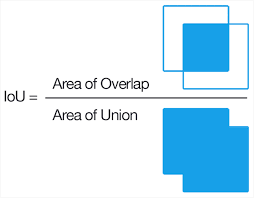

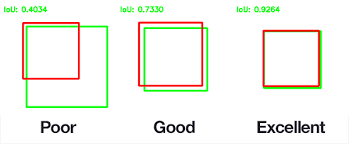

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou']);
plt.plot(history.history['val_iou']);
plt.title("Segmentation Model IOU Loss");
plt.ylabel("IOU loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Prediction</span> <a id=7></a>


In [ ]:
test_ids = list(mri_test.img_path)
test_mask = list(mri_test.mask_path)

In [ ]:
def prediction(test, model_seg):
  
    # empty list to store results
    mask, image_id,has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.img_path:
        

        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'img_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [ ]:
df_pred = prediction(mri_test, model)
df_pred

In [ ]:
df_pred = mri_test.merge(df_pred, on='img_path')
df_pred.head()

In [ ]:
count = 0
fig, axs = plt.subplots(3,5, figsize=(30,15))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.img_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Ground Truth')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.img_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with PREDICTED MASK')
        
        count +=1
    if (count==3):
        break

fig.tight_layout()

**Reference:** 
* [UNet model Original creator Reference link](https://github.com/zhixuhao/unet)
* [Kaggle Notebook - SAMUEL CORTINHAS](https://www.kaggle.com/code/samuelcortinhas/case-study-u-net-from-scratch#Application:-Tumor-detection)